<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Dataset_Preparation_C3VD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1twSOIn-ZceB3sK9l_9RUNXxDDVRqKh3g


Downloading...
From (original): https://drive.google.com/uc?id=1twSOIn-ZceB3sK9l_9RUNXxDDVRqKh3g
From (redirected): https://drive.google.com/uc?id=1twSOIn-ZceB3sK9l_9RUNXxDDVRqKh3g&confirm=t&uuid=6e61cdb5-0a18-4056-93cb-7393c566f2ea
To: /content/C3VD.zip
100% 615M/615M [00:12<00:00, 50.6MB/s]


In [ ]:
!unzip -q C3VD.zip

In [ ]:
from __future__ import absolute_import, division, print_function

import glob
import os
import random
import numpy as np
from PIL import Image  # using pillow-simd for increased speed
from PIL import ImageFile
import cv2

import torch
import torch.utils.data as data
from torchvision import transforms

ImageFile.LOAD_TRUNCATED_IMAGES=True

def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

class C3VDDataset(data.Dataset):
    """Superclass for monocular dataloaders

    Args:
        data_path
        filenames
        height
        width
        frame_idxs
        num_scales
        is_train
        img_ext
    """
    def __init__(self,
                 data_path,
                 height,
                 width,
                 frame_idxs,
                 num_scales,
                 model='train',
                 load_depth=False,
                 load_pose=False):
        super(C3VDDataset, self).__init__()

        self.data_path = data_path
        self.height = height
        self.width = width
        self.num_scales = num_scales
        self.interp = Image.LANCZOS

        self.frame_idxs = frame_idxs

        self.is_train = True if model == 'train' else False
        self.load_depth = load_depth
        self.load_pose = load_pose
        self.loader = pil_loader
        self.to_tensor = transforms.ToTensor()
        self.rescale_factor = 100 / 65535
        # We need to specify augmentations differently in newer versions of torchvision.
        # We first try the newer tuple version; if this fails we fall back to scalars

        self.K = np.array([[0.594, 0, 0.495, 0],
                           [0, 0.742, 0.506, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=np.float32)
        if model == 'train':
            #self.valid_files = np.array([1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 20, 22])
            self.valid_files = np.array([0])
        else:
            self.valid_files = np.array([0, 2, 5, 9, 12, 16, 19, 21])
        self.frame_idxs_max = np.max(np.abs(self.frame_idxs))

        try:
            self.brightness = (0.8, 1.2)
            self.contrast = (0.8, 1.2)
            self.saturation = (0.8, 1.2)
            self.hue = (-0.1, 0.1)
            transforms.transforms.ColorJitter(self.brightness,self.contrast,self.saturation,self.hue)
        except TypeError:
            self.brightness = 0.2
            self.contrast = 0.2
            self.saturation = 0.2
            self.hue = 0.1

        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s),
                                               interpolation=self.interp)
        self.scans = []
        self.video_files_all = [os.path.join(self.data_path, file) for file in os.listdir(self.data_path)]
        self.video_files_all.sort()
        print("all",self.video_files_all)
        print("valid",self.valid_files)

        self.video_files = [self.video_files_all[i] for i in self.valid_files]


        self.sequence_len = np.zeros([len(self.video_files)])
        for i, video_file in enumerate(self.video_files):
            image_paths = os.path.join(video_file, "*_color.png")
            video_base = os.path.basename(video_file)
            seq_image_paths = glob.glob(image_paths)
            seq_image_paths.sort()

            poses_path = os.path.join(video_file, "pose.txt")
            seq_poses = self.get_pose_video(poses_path)

            if self.frame_idxs_max > 0:
                seq_image_paths = seq_image_paths[self.frame_idxs_max:-self.frame_idxs_max]
                seq_poses = seq_poses[self.frame_idxs_max:-self.frame_idxs_max]
            if model == 'val':
                seq_image_paths = seq_image_paths[::80]
                seq_poses = seq_poses[::80]
            for j, seq_image_path in enumerate(seq_image_paths):
                filename = os.path.basename(seq_image_path)
                frame_index = int(filename[:4])
                seq_depth_path = os.path.join(self.data_path, video_base, "{:04d}_depth.tiff".format(frame_index))
                if os.path.exists(seq_image_path) and os.path.exists(seq_depth_path):
                    self.scans.append(
                        {
                            "seq_index": i,
                            "sequence": video_base,
                            "frame_index": frame_index,
                            "pose": seq_poses[j],
                            "length": len(seq_image_paths),
                        })
        print("Prepared C3VD dataset with %d sets of RGB, depth, normal and occlusion images." % (len(self.scans)))

    def __len__(self):
        return len(self.scans)

    def preprocess(self, inputs, color_aug):
        """Resize colour images to the required scales and augment if required

        We create the color_aug object in advance and apply the same augmentation to all
        images in this item. This ensures that all images input to the pose network receive the
        same augmentation.
        """
        for k in list(inputs):
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])

        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = self.to_tensor(f)
                inputs[(n + "_aug", im, i)] = self.to_tensor(color_aug(f))

    def get_color(self, video_base, frame_index, do_flip):
        color_path = os.path.join(self.data_path, video_base, "{:04d}_color.png".format(frame_index))
        color = self.loader(color_path)

        if do_flip:
            color = color.transpose(Image.FLIP_LEFT_RIGHT)

        return color

    def get_depth(self, video_base, frame_index, do_flip):
        depth_path = os.path.join(self.data_path, video_base, "{:04d}_depth.tiff".format(frame_index))
        depth_gt = cv2.imread(depth_path, 3)
        depth_gt = np.array(depth_gt[:, :, 0])
        depth_gt = depth_gt.astype(np.float32, order='C') * self.rescale_factor
        if do_flip:
            depth_gt = np.fliplr(depth_gt)

        return depth_gt

    def get_pose(self, video_base, frame_index):
        file_path = os.path.join(self.data_path, video_base, "pose.txt")
        with open(file_path, 'r') as f:
            lines = f.read().splitlines()
        values = lines[frame_index].split(',')
        pose = np.array(values).astype(np.float32).reshape([4,4]).T

        return pose

    def get_pose_video(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.read().splitlines()
        poses = []
        for line in lines:
            values = line.split(',')
            if len(values) != 16:
                raise ValueError("Invalid camera pose format")
            pose = np.array(values).reshape([4,4]).T
            poses.append(pose)

        return np.array(poses)

    def __getitem__(self, index):
        """Returns a single training item from the dataset as a dictionary.

        Values correspond to torch tensors.
        Keys in the dictionary are either strings or tuples:

            ("color", <frame_id>, <scale>)          for raw colour images,
            ("color_aug", <frame_id>, <scale>)      for augmented colour images,
            ("K", scale) or ("inv_K", scale)        for camera intrinsics,
            "stereo_T"                              for camera extrinsics, and
            "depth_gt"                              for ground truth depth maps.

        <frame_id> is either:
            an integer (e.g. 0, -1, or 1) representing the temporal step relative to 'index',
        or
            "s" for the opposite image in the stereo pair.

        <scale> is an integer representing the scale of the image relative to the fullsize image:
            -1      images at native resolution as loaded from disk
            0       images resized to (self.width,      self.height     )
            1       images resized to (self.width // 2, self.height // 2)
            2       images resized to (self.width // 4, self.height // 4)
            3       images resized to (self.width // 8, self.height // 8)
        """
        scan = self.scans[index]
        video_base = scan["sequence"]
        frame_index = scan["frame_index"]

        inputs = {}

        do_color_aug = self.is_train and random.random() > 0.5
        do_flip = self.is_train and random.random() > 0.5

        inputs["frame_id"] = torch.from_numpy(np.array(frame_index))

        for i in self.frame_idxs:
            # print(frame_index + i, "color", i, -1)
            inputs[("color", i, -1)] = self.get_color(video_base, frame_index + i, do_flip)

        # adjusting intrinsics to match each scale in the pyramid
        for scale in range(self.num_scales):
            K = self.K.copy()
            K[0, :] *= self.width // (2 ** scale)
            K[1, :] *= self.height // (2 ** scale)


            inv_K = np.linalg.pinv(K)

            inputs[("K", scale)] = torch.from_numpy(K)
            inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

        if do_color_aug:
            color_aug = transforms.ColorJitter(self.brightness,self.contrast,self.saturation,self.hue)
        else:
            color_aug = (lambda x: x)

        self.preprocess(inputs, color_aug)
        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
            del inputs[("color_aug", i, -1)]

        if self.load_depth:
            # print('depth:',frame_index)
            depth_gt = self.get_depth(video_base, frame_index, do_flip)
            inputs["depth_gt"] = np.expand_dims(depth_gt, 0)
            inputs["depth_gt"] = torch.from_numpy(inputs["depth_gt"].astype(np.float32))

        if self.load_pose:
            for i in self.frame_idxs:
                inputs[("pose", i)] = torch.from_numpy(self.get_pose(video_base, frame_index + i))
                inputs["sequence"] = video_base
                inputs["keyframe"] = "0"
        return inputs


In [ ]:
ds = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)

test = ds[0]

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.


In [ ]:
test.keys()

dict_keys(['frame_id', ('K', 0), ('inv_K', 0), ('K', 1), ('inv_K', 1), ('K', 2), ('inv_K', 2), ('K', 3), ('inv_K', 3), ('color', 0, 0), ('color', 0, 1), ('color', 0, 2), ('color', 0, 3), ('color', -1, 0), ('color', -1, 1), ('color', -1, 2), ('color', -1, 3), ('color', 1, 0), ('color', 1, 1), ('color', 1, 2), ('color', 1, 3), ('color_aug', 0, 0), ('color_aug', 0, 1), ('color_aug', 0, 2), ('color_aug', 0, 3), ('color_aug', -1, 0), ('color_aug', -1, 1), ('color_aug', -1, 2), ('color_aug', -1, 3), ('color_aug', 1, 0), ('color_aug', 1, 1), ('color_aug', 1, 2), ('color_aug', 1, 3), 'depth_gt'])

In [ ]:
test['color', 0, 0].shape, test['depth_gt'].shape, test['color', 1, 0].shape

(torch.Size([3, 256, 320]),
 torch.Size([1, 1080, 1350]),
 torch.Size([3, 256, 320]))

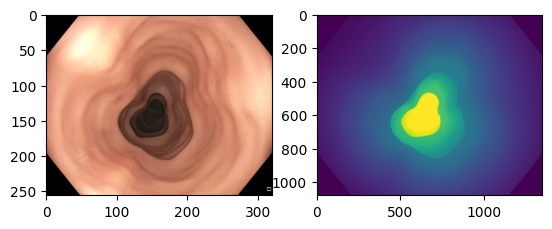

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(121); plt.imshow(test['color', 0, 0].permute(1,2,0))
plt.subplot(122); plt.imshow(test['depth_gt'][0])